#### Описание данных

_Размер данных:_
- 13.9 миллионов строк
- 12 признаков + 2 целевых переменных

_Структура данных_
1. Анонимизированные признаки (`f0-f11`):
    - 12 числовых признаков (числа с плавающей запятой)
    - Признаки описывают характеристики пользователей и их историческое поведение
2. Признак воздействия `exposure`:
    - Бинарный признак (0/1), показывающий, был ли пользователь фактически подвергнут рекламному воздействию _(Фактическое воздействие (реализованное воздействие)_
    - 1: Пользователь реально увидел рекламу
    - 0: Пользователь не увидел рекламу, несмотря на запланированное воздействие
3. Признак воздействия (`treatment`):
    - Бинарная переменная (0/1), _(Планируемое воздействие (назначение в тестовую группу))_
    - 1: Пользователь получил рекламное воздействие (показ баннера)
    - 0: Пользователь в контрольной группе (воздействие не применялось)
4. Целевые переменные:
    - `visit`: Факт посещения сайта после воздействия (бинарный: 0/1)
    - `conversion`: Факт совершения покупки (бинарный: 0/1)

__Ключевые особенности__

_Задача uplift-моделирования:_
1. Позволяет предсказать индивидуальный прирост конверсии от рекламы
2. Помогает выделить группы пользователей:
    - `Persuadables`: Те, кто покупает только после рекламы
    - `Sure things`: Купят в любом случае
    - `Lost causes`: Не купят даже с рекламой
    - `Sleeping dogs`: Могут отказаться из-за рекламы

_Основные задачи:_
1. Предсказание uplift:
    - Насколько увеличится вероятность покупки при показе рекламы конкретному пользователю
2. Оптимизация маркетингового бюджета:
    - Показывать рекламу только тем, кто положительно реагирует на воздействие
    - Исключить показы для "Sleeping dogs" (кто может разозлиться)
3. Оценка эффективности кампаний:
    - Расчет реального прироста конверсии (incremental conversion)
    - Оценка ROI рекламных кампаний

#### 1. Загрузка данных и EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Настройки визуализации
sns.set_style("whitegrid", {'axes.grid': True, 'grid.linestyle': '--'})
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 90
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'x-large'

In [4]:
filepath = './' # Путь к датасету

In [5]:
df = pd.read_csv(filepath)
df.head(1)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [6]:
# Информация о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [7]:
# Статистическое описание числовых признаков
df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01,8.500001e-01,2.916680e-03,4.699200e-02,3.063122e-02
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02,3.570713e-01,5.392748e-02,2.116217e-01,1.723164e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [8]:
# Количество уникальных значений
df.nunique()

f0            2181959
f1                 60
f2            2051900
f3                552
f4                260
f5                132
f6               1645
f7             622143
f8               3743
f9               1594
f10            517372
f11               136
treatment           2
conversion          2
visit               2
exposure            2
dtype: int64

In [11]:
# Количество пропусков для каждого столбца
df.isnull().sum().sort_values(ascending=False)

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

In [10]:
# Проверка распределения treatment/control
print(df['treatment'].value_counts(normalize=True))
print(df['conversion'].value_counts(normalize=True))

treatment
1    0.85
0    0.15
Name: proportion, dtype: float64
conversion
0    0.997083
1    0.002917
Name: proportion, dtype: float64


#### 2. Расчёт среднего эффекта воздействия (ATE)

ATE (Average Treatment Effect) — это средний эффект от воздействия (в данном случае, рекламной кампании) на целевую переменную.

Функция `calculate_ate`:  
- Эта функция рассчитывает ATE для заданной целевой переменной (conversion или visit).
- Она группирует данные по признаку treatment и вычисляет среднее, сумму и количество для каждой группы.
- Далее рассчитывается сам ATE как разница между средними значениями в тестовой и контрольной группах.
- Для оценки статистической значимости используется Z-тест.

In [49]:
def calculate_ate(df, outcome_col):
    """
    Рассчитывает средний эффект воздействия (ATE) и его статистическую значимость (Z-тест).

    Args:
        df (pd.DataFrame): DataFrame с данными.
        outcome_col (str): Название колонки с исходом ('conversion' или 'visit').
    """
    print(f"\nАнализ для исхода: '{outcome_col}'")

    # Группировка по группам (treatment/control) и расчет базовых метрик
    summary = df.groupby('treatment')[outcome_col].agg(['mean', 'sum', 'count'])

    # Проверка, что обе группы (0 и 1) присутствуют в данных
    if 0 not in summary.index or 1 not in summary.index:
        print("Ошибка: в данных отсутствует контрольная или тестовая группа.")
        return

    # Извлечение скалярных значений для расчетов
    mean_treat = summary.loc[1, 'mean']
    mean_control = summary.loc[0, 'mean']
    
    count_treat = summary.loc[1, 'count']
    count_control = summary.loc[0, 'count']
    
    sum_treat = summary.loc[1, 'sum']
    sum_control = summary.loc[0, 'sum']

    # Расчет ATE (Average Treatment Effect)
    ate = mean_treat - mean_control

    # Z-тест для разности долей для определения статистической значимости
    # Объединенная пропорция
    p_pool = (sum_treat + sum_control) / (count_treat + count_control)
    
    # Стандартная ошибка
    se = np.sqrt(p_pool * (1 - p_pool) * (1/count_treat + 1/count_control))
    
    # Z-статистика
    if se == 0:
        z_score = np.inf if ate > 0 else -np.inf
        p_value = 0.0
    else:
        z_score = ate / se
        # p-value (двусторонний тест)
        p_value = 2 * (1 - norm.cdf(abs(z_score)))

    print("Сводная таблица по группам:")
    print(summary)
    print(f"\nСредний эффект воздействия (ATE): {ate:.4%}")
    print(f"Абсолютный прирост: {ate:.4f}")
    print(f"Z-статистика: {z_score:.2f}, p-value: {p_value:.5f}")
    
    if p_value < 0.05:
        print("Результат является статистически значимым (p < 0.05).")
    else:
        print("Результат не является статистически значимым (p >= 0.05).")

In [50]:
# Оценка общего эффекта кампании (ATE)
calculate_ate(df, 'conversion')
calculate_ate(df, 'visit')


Анализ для исхода: 'conversion'
Сводная таблица по группам:
               mean    sum     count
treatment                           
0          0.001938   4063   2096937
1          0.003089  36711  11882655

Средний эффект воздействия (ATE): 0.1152%
Абсолютный прирост: 0.0012
Z-статистика: 28.52, p-value: 0.00000
Результат является статистически значимым (p < 0.05).

Анализ для исхода: 'visit'
Сводная таблица по группам:
               mean     sum     count
treatment                            
0          0.038201   80105   2096937
1          0.048543  576824  11882655

Средний эффект воздействия (ATE): 1.0342%
Абсолютный прирост: 0.0103
Z-статистика: 65.25, p-value: 0.00000
Результат является статистически значимым (p < 0.05).


#### 3. Расчёт NWOE/NIV

NWOE (Net Weight of Evidence) и NIV (Net Information Value) — это метрики, которые используются для оценки предиктивной силы признаков в uplift-моделировании.

1. Функция `calculate_nwoe_niv`:
    - Эта функция рассчитывает NWOE и NIV для одного признака.
    - Она разбивает непрерывный признак на бины (интервалы).
    - Далее рассчитывается uplift (прирост) для каждого бина.
    - NWOE вычисляется на основе uplift и долей исхода в каждой группе.
    - NIV — это сумма NWOE по всем бинам.

2. Расчет для всех признаков:  
    В цикле вы вызываете эту функцию для каждого признака и сохраняете результаты.

In [44]:
def calculate_nwoe_niv(df, feature, outcome_col, n_bins=10):
    """
    Рассчитывает Net Weight of Evidence (NWOE) и Net Information Value (NIV)
    для одного признака.

    Args:
        df (pd.DataFrame): DataFrame с данными.
        feature (str): Название колонки с признаком.
        outcome_col (str): Название колонки с исходом ('conversion' или 'visit').
        n_bins (int): Количество бинов для дискретизации непрерывного признака.

    Returns:
        tuple: (DataFrame с детальным расчетом по бинам,
                float: итоговое значение NIV для признака)
    """
    data = df[[feature, 'exposure', outcome_col]].copy()
    data['bin'] = pd.qcut(data[feature], q=n_bins, duplicates='drop', labels=False)

    grouped = data.groupby(['bin', 'exposure'])[outcome_col].agg(['sum', 'count']).unstack().fillna(0)
    
    # Для избежания деления на ноль
    epsilon = 1e-9
    
    # Расчет доли исхода (rate) для control (Exposure=0) и treatment (Exposure=1)
    rate_control = (grouped[('sum', 0)] + epsilon) / (grouped[('count', 0)] + 2 * epsilon)
    rate_treat = (grouped[('sum', 1)] + epsilon) / (grouped[('count', 1)] + 2 * epsilon)
    
    # Расчет Uplift
    uplift = rate_treat - rate_control
    
    # Расчет NWOE
    nwoe = uplift * np.log(rate_treat / rate_control)
    
    # Итоговый NIV для признака
    niv = nwoe.sum()
    
    # Сборка итоговой таблицы
    results_df = pd.DataFrame({
        'bin': grouped.index,
        'count_control': grouped[('count', 0)],
        'count_treat': grouped[('count', 1)],
        'rate_control': rate_control,
        'rate_treat': rate_treat,
        'uplift': uplift,
        'nwoe': nwoe
    }).reset_index(drop=True)
    
    return results_df, niv

In [46]:
# Расчет NWOE и NIV для всех признаков
feature_cols = [f'f{i}' for i in range(12)]
outcome_to_analyze = 'conversion'

print(f"Расчет NIV для исхода '{outcome_to_analyze}'")
niv_results = {}
detailed_nwoe_results = {}

for feature in feature_cols:
    print(f"Анализ признака: {feature}...")
    try:
        nwoe_df, niv = calculate_nwoe_niv(df, feature, outcome_to_analyze)
        niv_results[feature] = niv
        detailed_nwoe_results[feature] = nwoe_df
    except Exception as e:
        print(f"  Не удалось обработать признак {feature}: {e}")
        niv_results[feature] = 0 # Записываем 0, чтобы не прерывать анализ

print("Расчет NIV завершен.")

Расчет NIV для исхода 'conversion'
Анализ признака: f0...
Анализ признака: f1...
Анализ признака: f2...
Анализ признака: f3...
Анализ признака: f4...
Анализ признака: f5...
Анализ признака: f6...
Анализ признака: f7...
Анализ признака: f8...
Анализ признака: f9...
Анализ признака: f10...
Анализ признака: f11...
Расчет NIV завершен.


#### 4. Визуализация результатов

Функция `plot_niv_summary`:
- Эта функция строит столбчатую диаграмму, которая показывает итоговые значения NIV для всех признаков. Это позволяет легко сравнить предиктивную силу разных признаков.

Функция `plot_feature_detail`:
- Эта функция строит детальный график для одного признака, показывая uplift и NWOE по бинам. Это помогает понять, как меняется эффект от воздействия в зависимости от значения признака.

In [51]:
def plot_niv_summary(niv_results):
    """
    Визуализирует итоговые значения NIV для всех признаков.

    Args:
        niv_results (dict): Словарь с NIV для каждого признака.
    """
    if not niv_results:
        print("Нет данных для построения графика NIV.")
        return
        
    niv_df = pd.DataFrame(list(niv_results.items()), columns=['feature', 'NIV']).sort_values('NIV', ascending=False)

    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(x='NIV', y='feature', data=niv_df, palette='viridis_r')
    plt.title('Net Information Value (NIV) - Сила признаков для предсказания Uplift', fontsize=16, pad=20)
    plt.xlabel('NIV')
    plt.ylabel('Признак')

    for i, (value, name) in enumerate(zip(niv_df['NIV'], niv_df['feature'])):
        barplot.text(value + value * 0.01, i, f'{value:.4f}', color='black', ha="left", va='center')
        
    plt.show()

In [53]:
def plot_feature_detail(nwoe_df, feature_name, outcome_col):
    """
    Визуализирует детальный анализ по бинам для одного признака.

    Args:
        nwoe_df (pd.DataFrame): DataFrame с результатами от calculate_nwoe_niv.
        feature_name (str): Название признака.
        outcome_col (str): Название исхода.
    """
    fig, ax1 = plt.subplots()

    # График Uplift
    color_uplift = 'royalblue'
    ax1.plot(nwoe_df['bin'], nwoe_df['uplift'], color=color_uplift, marker='o', linestyle='-', label='Uplift (Прирост)')
    ax1.set_xlabel('Бин признака (сегмент пользователей)')
    ax1.set_ylabel('Uplift (Rate Treat - Rate Control)', color=color_uplift)
    ax1.tick_params(axis='y', labelcolor=color_uplift)
    ax1.axhline(0, color='black', linestyle='--', linewidth=1)
    ax1.set_xticks(nwoe_df['bin']) # Четкие метки для каждого бина

    # Вторая ось Y для NWOE
    color_nwoe = 'seagreen'
    ax2 = ax1.twinx()
    ax2.bar(nwoe_df['bin'], nwoe_df['nwoe'], color=color_nwoe, alpha=0.5, label='NWOE')
    ax2.set_ylabel('Net Weight of Evidence (NWOE)', color=color_nwoe)
    ax2.tick_params(axis='y', labelcolor=color_nwoe)

    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.title(f'Детальный анализ признака "{feature_name}" (Исход: {outcome_col})', fontsize=16, pad=20)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

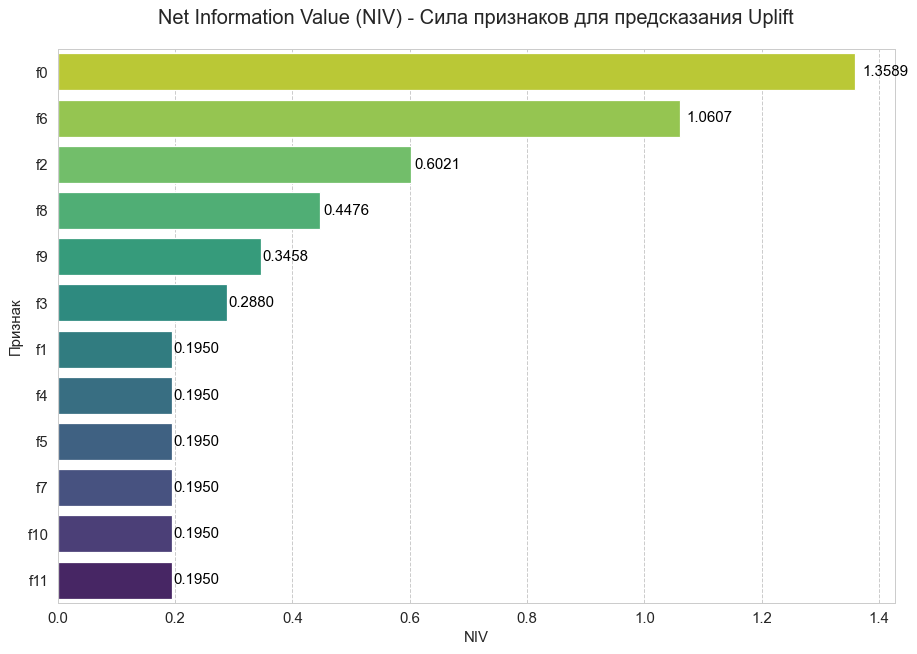

In [57]:
plot_niv_summary(niv_results)

Детальный анализ для топ-3 признаков


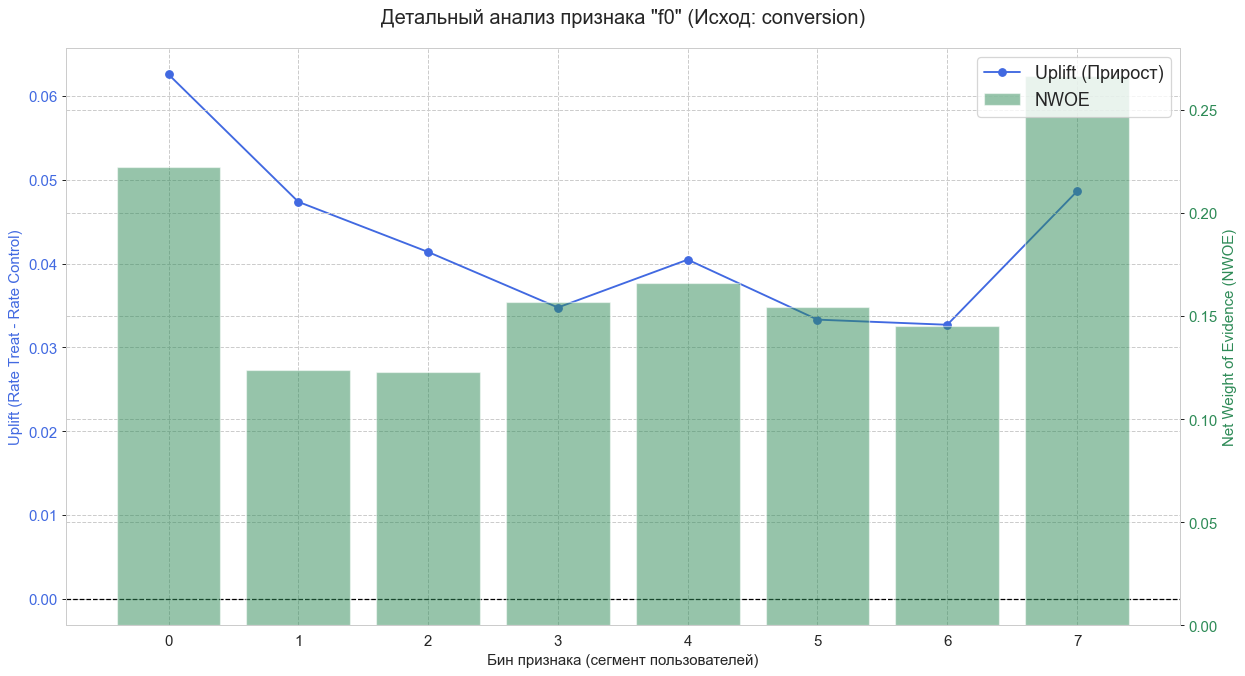

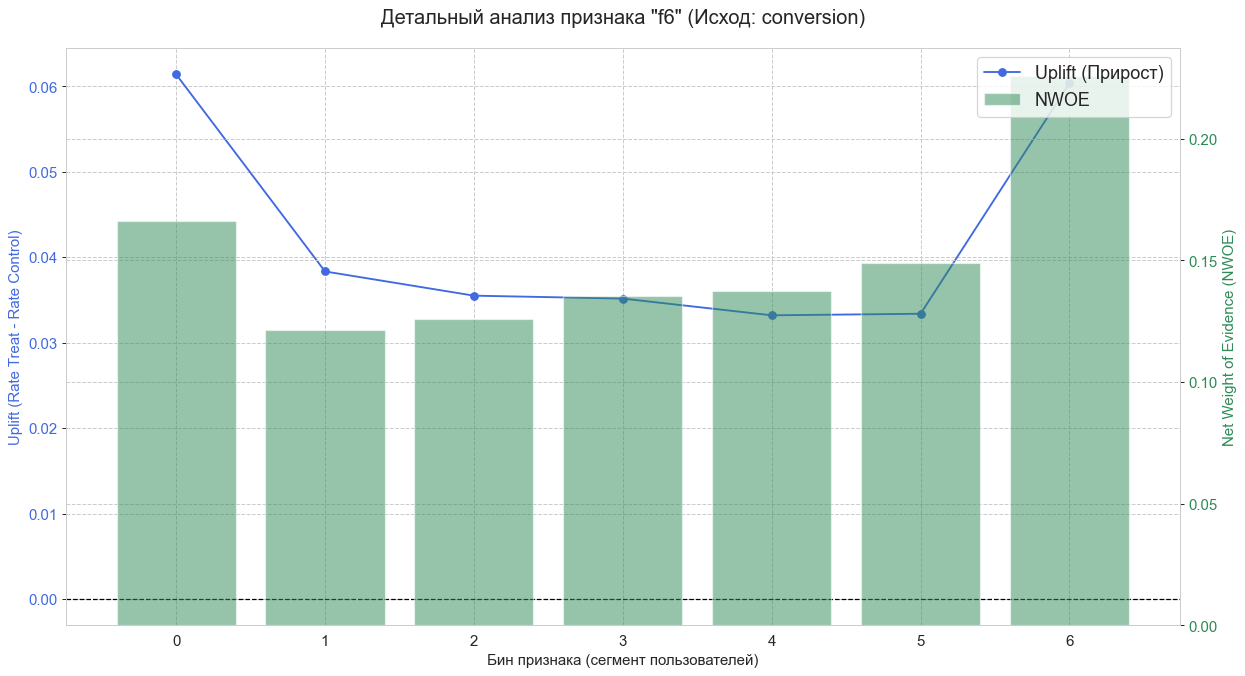

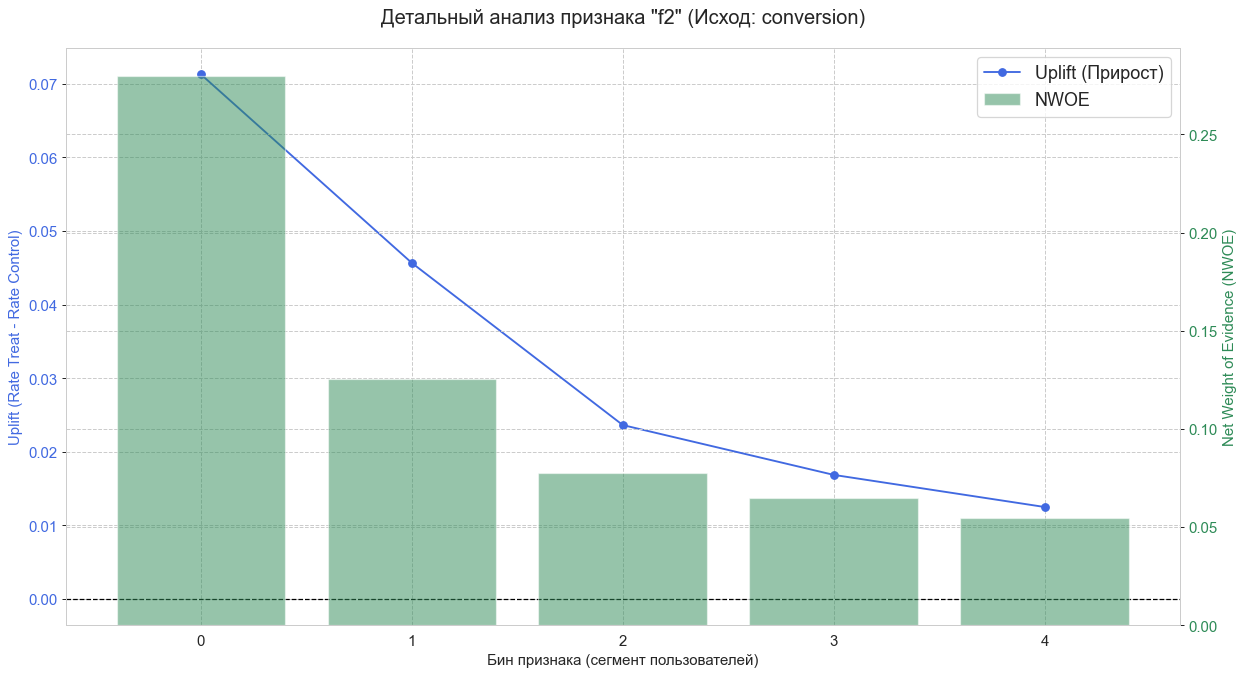

In [55]:
niv_summary_df = pd.DataFrame(list(niv_results.items()), columns=['Признак', 'NIV']).sort_values('NIV', ascending=False)
top_features = niv_summary_df.head(3)['Признак'].tolist()

print(f"Детальный анализ для топ-{len(top_features)} признаков")
for feature in top_features:
    if feature in detailed_nwoe_results:
        plot_feature_detail(detailed_nwoe_results[feature], feature, outcome_to_analyze)

#### 5. TL;DR

Кампания продемонстрировала статистически значимый положительный средний эффект воздействия (ATE) как на визиты, так и на конверсии, что подтверждает её общую эффективность.  
Выявлены ключевые драйверы Uplift: с помощью метрики NIV были успешно проранжированы все 12 признаков по их способности предсказывать инкрементальный эффект. Это позволило выявить наиболее важные характеристики пользователей, влияющие на их отклик на рекламу.  
Идентифицированы сегменты с различным откликом: детальный анализ NWOE для каждого признака выявил конкретные сегменты пользователей (определяемые бинами признаков).  
Результаты являются основой для создания системы таргетинга. Вместо показа рекламы всем подряд, можно нацелиться на сегменты пользователей с высоким ожидаемым uplift'ом, чтобы максимизировать возврат инвестиций (ROI) и не тратить бюджет на тех, кто совершил бы покупку и без рекламы, а также на пользователей, для которых реклама контрпродуктивнамы.